In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load datasets
players = pd.read_csv('/Users/chizzycasa/Downloads/archive/players.csv')
passing = pd.read_csv('/Users/chizzycasa/Downloads/archive/passer.csv')
rushing = pd.read_csv('/Users/chizzycasa/Downloads/archive/rusher.csv')
receiving = pd.read_csv('/Users/chizzycasa/Downloads/archive/receiver.csv')
kicks = pd.read_csv('/Users/chizzycasa/Downloads/archive/kicks.csv')
kick_returns = pd.read_csv('/Users/chizzycasa/Downloads/archive/kickReturns.csv')
tackles = pd.read_csv('/Users/chizzycasa/Downloads/archive/tackles.csv')
sacks = pd.read_csv('/Users/chizzycasa/Downloads/archive/sacks.csv')
fumbles = pd.read_csv('/Users/chizzycasa/Downloads/archive/fumbles.csv')

# Display initial rows of data for inspection
players.head(), passing.head(), rushing.head(), receiving.head(), kicks.head()

(   playerId nameFirst nameLast       nameFull position  collegeId    nflId  \
 0  19770001     Ricky     Bell     Ricky Bell       RB      90089  2509366   
 1  19770002      Tony  Dorsett   Tony Dorsett       RB      15260  2513084   
 2  19770003     Eddie  Edwards  Eddie Edwards       DE      33124  2513479   
 3  19770004    Marvin   Powell  Marvin Powell       OT      90089  2523462   
 4  19770005      Gary    Jeter     Gary Jeter       DE      90089  2517530   
 
    combineId     college  heightInches  ...         dob ageAtDraft  \
 0        NaN         USC          74.0  ...  1955-04-08  22.084932   
 1        NaN  Pittsburgh          71.0  ...  1954-04-07  23.087671   
 2        NaN  Miami (FL)          77.0  ...  1954-04-25  23.038356   
 3        NaN         USC          77.0  ...  1955-08-30  21.690411   
 4        NaN         USC          76.0  ...  1955-01-24  22.287671   
 
                                     playerProfileUrl     homeCity homeState  \
 0  http://www.n

In [3]:
# Remove duplicates from each dataset based on playerId
players = players.drop_duplicates(subset=['playerId'])
passing = passing.drop_duplicates(subset=['playerId'])
rushing = rushing.drop_duplicates(subset=['playerId'])
receiving = receiving.drop_duplicates(subset=['playerId'])
kicks = kicks.drop_duplicates(subset=['playerId'])
kick_returns = kick_returns.drop_duplicates(subset=['playerId'])
tackles = tackles.drop_duplicates(subset=['playerId'])
sacks = sacks.drop_duplicates(subset=['playerId'])
fumbles = fumbles.drop_duplicates(subset=['playerId'])

# Now perform the merge with suffixes to avoid column name conflicts
df = players.merge(passing, on="playerId", how="left", suffixes=('_players', '_passing'))
df = df.merge(rushing, on="playerId", how="left", suffixes=('', '_rushing'))
df = df.merge(receiving, on="playerId", how="left", suffixes=('', '_receiving'))
df = df.merge(kicks, on="playerId", how="left", suffixes=('', '_kicks'))
df = df.merge(kick_returns, on="playerId", how="left", suffixes=('', '_kick_returns'))
df = df.merge(tackles, on="playerId", how="left", suffixes=('', '_tackles'))
df = df.merge(sacks, on="playerId", how="left", suffixes=('', '_sacks'))
df = df.merge(fumbles, on="playerId", how="left", suffixes=('', '_fumbles'))

# Check for missing values
df.isnull().sum()

playerId           0
nameFirst          0
nameLast           0
nameFull           0
position           1
               ...  
fumPosition    20570
fumType        20570
fumOOB         20570
fumTurnover    20588
fumNull        20570
Length: 112, dtype: int64

In [4]:
# Print column names to check if 'optimalTeam' exists
print(df.columns)

Index(['playerId', 'nameFirst', 'nameLast', 'nameFull', 'position',
       'collegeId', 'nflId', 'combineId', 'college', 'heightInches',
       ...
       'sackEnd', 'sackNull', 'fumId', 'playId_fumbles', 'teamId_fumbles',
       'fumPosition', 'fumType', 'fumOOB', 'fumTurnover', 'fumNull'],
      dtype='object', length=112)


In [5]:
# Create 'optimalTeam' column based on a condition (e.g., top 50 players by passing yards)
df['optimalTeam'] = (df['passLength'] > df['passLength'].median()).astype(int)

In [6]:
# Adjusted feature list based on the actual column names
features = ['passLength', 'rushYards', 'recYards', 'kickReturnYds', 'kickReturnYds', 
            'tackleYdsScrim', 'sackYards', 'fumOOB']

# Extract feature columns and target variable
X = df[features]
y = df['optimalTeam']  # Now that the 'optimalTeam' column exists, this should work

In [7]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Create a pipeline with an imputer and MLPClassifier
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Impute missing values with the mean
    MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000, activation='relu', solver='adam', random_state=42)
)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000,
                               random_state=42))])

Accuracy: 1.00


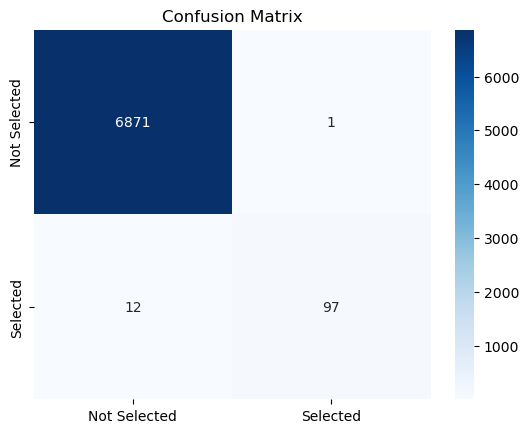

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6872
           1       0.99      0.89      0.94       109

    accuracy                           1.00      6981
   macro avg       0.99      0.94      0.97      6981
weighted avg       1.00      1.00      1.00      6981



In [10]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Selected", "Selected"], yticklabels=["Not Selected", "Selected"])
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

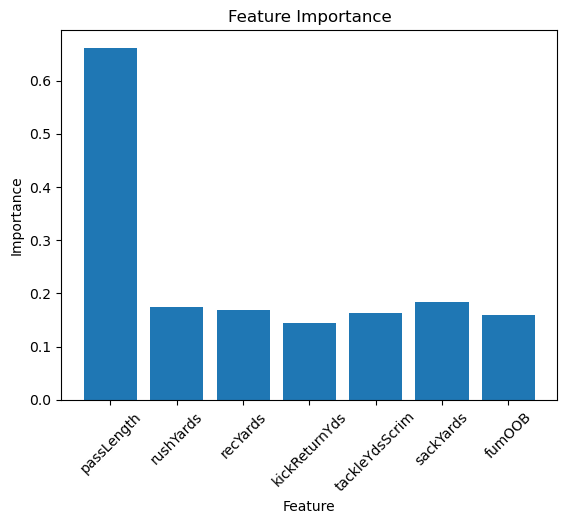

In [11]:
# Extract the coefficients (weights) from the first layer of the MLP model
coefs = pipeline.named_steps['mlpclassifier'].coefs_[0]

# Compute the importance of each feature as the absolute mean of the weights across all neurons in the first layer
feature_importances = np.mean(np.abs(coefs), axis=1)

# Plot feature importance
plt.bar(features, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Sort players by their predicted selection score and display the top players for each category
df['prediction'] = pipeline.predict(X)

optimal_offense = df[df['prediction'] == 1].nlargest(11, 'passLength')  # Top offensive players
optimal_special_teams = df[df['prediction'] == 1].nlargest(11, 'kickReturnYds')  # Special teams
optimal_defense = df[df['prediction'] == 1].nlargest(11, 'tackleYdsScrim')  # Defensive players

print("Optimal Offense:")
print(optimal_offense[['playerId', 'passLength', 'rushYards', 'recYards']])

print("Optimal Special Teams:")
print(optimal_special_teams[['playerId', 'kickReturnYds']])

print("Optimal Defense:")
print(optimal_defense[['playerId', 'tackleYdsScrim', 'sackYards', 'fumOOB']])

Optimal Offense:
       playerId  passLength  rushYards  recYards
14231  20080205        52.0        0.0       4.0
21189  20170562        50.0        2.0      20.0
17633  20130063        46.0        2.0       9.0
18422  20140063        46.0       10.0       0.0
18840  20140712        46.0        4.0       NaN
21600  20180001        46.0        4.0      -6.0
12799  20060119        45.0       -1.0       3.0
6852   19950005        44.0        2.0       NaN
20319  20160552        42.0        4.0       NaN
20827  20170052        42.0       13.0       NaN
11124  20030681        41.0        7.0       NaN
Optimal Special Teams:
       playerId  kickReturnYds
10806  20030222           35.0
13209  20060673           30.0
16361  20110575           30.0
19098  20141042           27.0
10961  20030515           18.0
6275   19930200           15.0
13463  20070101           14.0
16835  20120070           14.0
14863  20090222           12.0
18550  20140191           12.0
21277  20170650            9.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
